# System identification of Lindblad master equation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, inv, norm
from qutip import rand_herm, rand_dm, mesolve, Qobj

from ncpol2sdpa import generate_variables, SdpRelaxation
from sympy import Matrix, I, eye, re, im, diag

# utilities

In [2]:
def unknown_complex_matrix(name, n):
    return Matrix(n, n, generate_variables('Re' + name, n * n)) \
        + I * Matrix(n, n, generate_variables('Im' + name, n * n))

In [3]:
def unknown_hermitian_matrix(name, n):
    
    x = generate_variables(name, n ** 2)
    M = diag(*x[:n])
    M /= 2
    x = x[n:]

    for i in range(n - 1):
        for j in range(i + 1, n):
            M[i, j] = x.pop() + I * x.pop()
            
    M += M.H
    
    return M

# Generate data

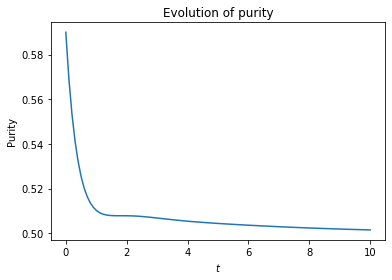

In [4]:
H_exact = rand_herm(2)
A_exact = rand_herm(2) + 1j * rand_herm(2)

results = mesolve(H_exact, rand_dm(2), np.linspace(0, 10, 100), [A_exact])

plt.title("Evolution of purity")
plt.plot(results.times, [_.purity() for _ in results.states])
plt.xlabel('$t$')
plt.ylabel('Purity')
plt.show()

In [5]:
# Comvert states to numpy array
rho = [_.data.toarray() for _ in results.states]

# Define objective function

In [6]:
H = unknown_hermitian_matrix('H', 2)
A = unknown_complex_matrix('A', H.shape[0])

def rhs(rho):
    """
    Right hand side of the Lindblad master equation
    """
    return -I * (H @ rho - rho @ H) \
        + A @ rho @ A.H - (A.H @ A @ rho - rho @ A.H @ A) / 2

In [7]:
# the density matrix integrated over time
int_rho = np.trapz(
    rho,
    x=results.times,
    axis=0
)

In [8]:
obj = (rho[-1] - rho[0] - rhs(int_rho)).norm() ** 2
obj = re(obj.simplify())

In [ ]:
level = 3

sdp = SdpRelaxation(list(obj.free_symbols))
sdp.get_relaxation(level, objective=obj)
sdp.solve(solver='mosek')

# extract the values of control
if sdp.status == 'optimal':
    solution = {var: sdp[var] for var in sdp.variables}
else:
    solution = None

In [ ]:
obj.subs(solution)